# Vietnamese Emotion Classification using PhoBERT
- Input:
    - Sentence
- Output:
    - enjoyment (vui vẻ)
    - disgust (ghê tởm)
    - sadness (buồn)
    - anger (giận dữ)
    - surprise (ngạc nhiên)
    - fear (sợ hãi)
    - others (khác)

Link Dataset: https://www.kaggle.com/code/hmthanh/vietnamese-emotion-classification-using-phobert/notebook

## 1. Import library

In [55]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from nltk.corpus import stopwords


from bs4 import BeautifulSoup
from bs4.element import Tag
import requests
import csv
import pandas as pd
import openpyxl

## Craw Data

In [56]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import csv

In [57]:
def save(name, a):
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    dataset = pd.DataFrame(data=df)
    dataset.to_excel(f'./DataSet/{name}.xlsx', encoding='utf-8-sig')

In [58]:
def get_data(name, dict_url):

    driver = webdriver.Edge()

    Contents = []
    Topic = []
    dictionary = {'Content': Contents, 'Topic': Topic}

    for _topic, quantity in dict_url.items():
        driver.get(f'https://vtv.vn/{_topic}.htm')
        content = []
        count = 0
        status = True
        while status:
            items = driver.find_elements(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[1]/ul/li')

            for item in items:
                if count >= quantity:
                    status = False
                    break
                # Tìm tiêu đề tin tức
                content.append(item.find_element(By.XPATH,  './/h4/a').text)
                topic = [_topic for _ in range(len(content))]
                count += 1
            # Tìm nút "Xem thêm"
            load_more_button = driver.find_element(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[2]/a')

            if not load_more_button.is_displayed():
                break
            load_more_button.click()

            time.sleep(5)
        Topic.extend(topic)
        Contents.extend(content)
    save(name, dictionary)

In [59]:
dict_url_big = {    'chinh-tri':        1856,
                    'xa-hoi':           1005,
                    'kinh-te':          2326,
                    'truyen-hinh':      2164,
                    'cong-nghe':        548,
                    'doi-song':         1456,
                    'van-hoa-giai-tri': 1564
                }

dict_url_small = {  'chinh-tri':        213,
                    'xa-hoi':           113,
                    'kinh-te':          566,
                    'truyen-hinh':      36,
                    'cong-nghe':        156,
                    'doi-song':         102,
                    'van-hoa-giai-tri': 189
                }

# get_data("big_data", dict_url_big)
# get_data("small_data", dict_url_small)

## Load Data

In [60]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Content', 'Topic']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [61]:
df_small = get_data('D:/Learning/Data_Analytics/Crawl Data/End_term_VN/DataSet/small_data.xlsx')
df_big = get_data('D:/Learning/Data_Analytics/Crawl Data/End_term_VN/DataSet/big_data.xlsx')

In [62]:
df_small.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [63]:
df_big.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


## Exploratory data analysis

In [64]:
def plot_topic(df):
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Topic', data=df)
    plt.show()

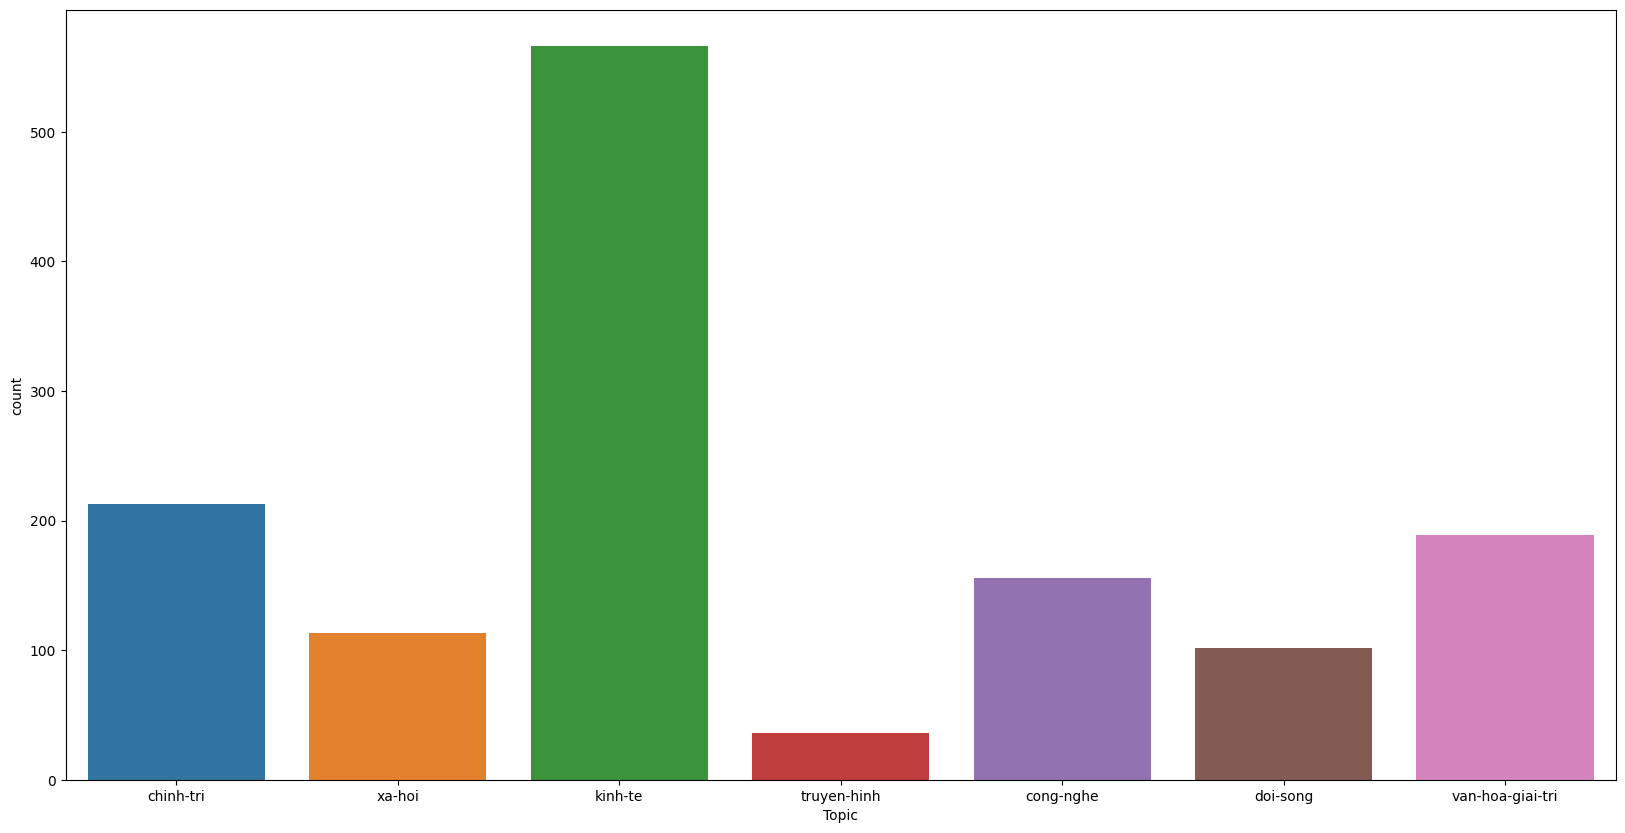

In [65]:
plot_topic(df_small)

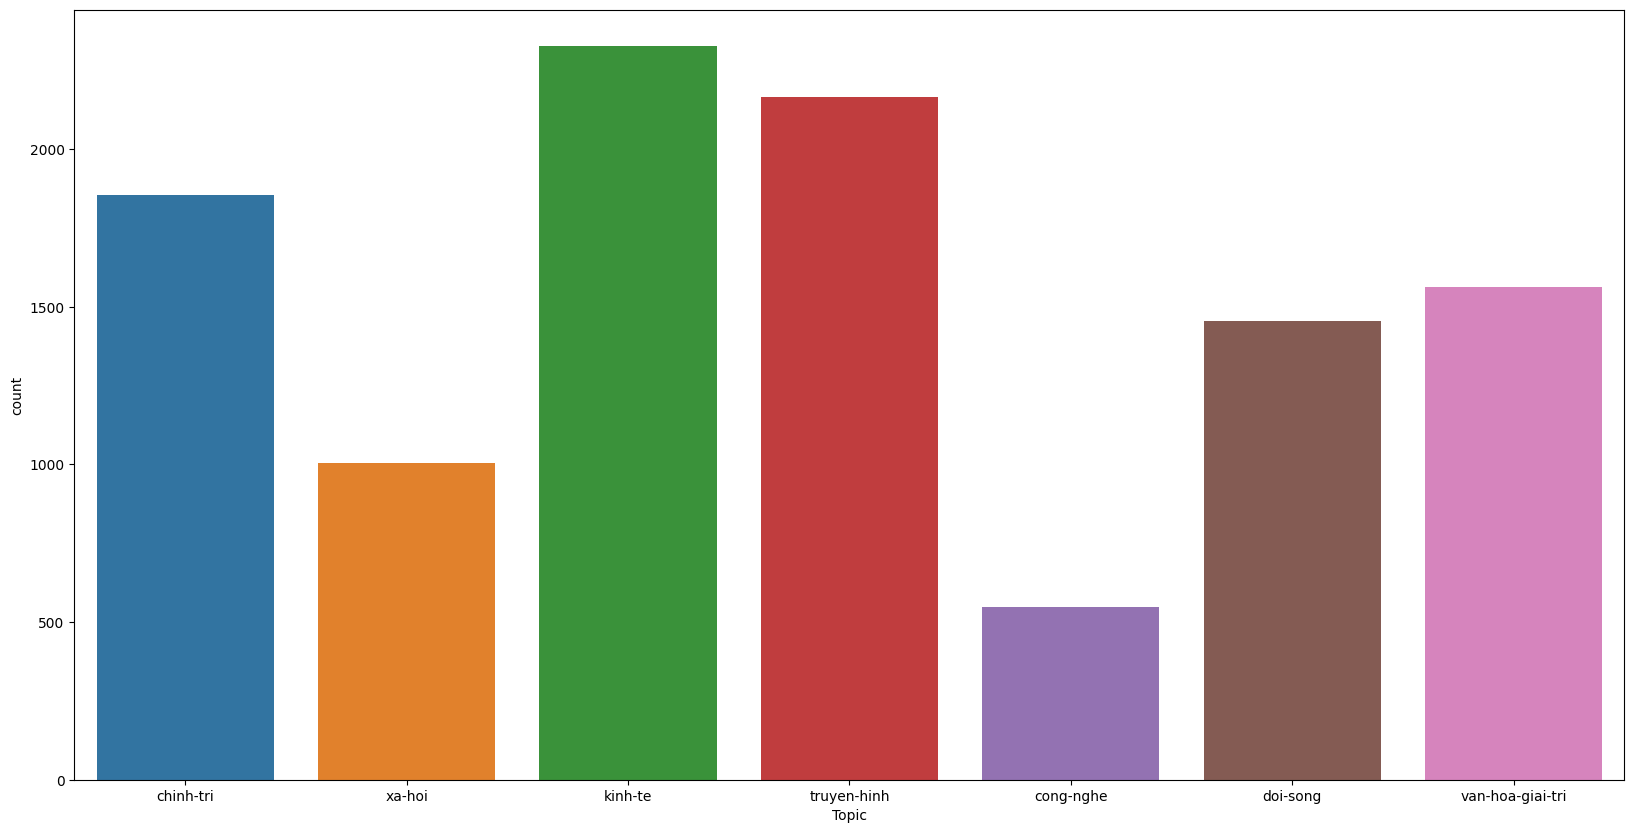

In [66]:
plot_topic(df_big)

In [67]:
df_big['Topic'].value_counts()

kinh-te             2326
truyen-hinh         2164
chinh-tri           1856
van-hoa-giai-tri    1564
doi-song            1456
xa-hoi              1005
cong-nghe            548
Name: Topic, dtype: int64

In [68]:
df_small['Topic'].value_counts()

kinh-te             566
chinh-tri           213
van-hoa-giai-tri    189
cong-nghe           156
xa-hoi              113
doi-song            102
truyen-hinh          36
Name: Topic, dtype: int64

In [69]:
def group_topic(topic):
    if topic in ['chinh-tri']:
        return 'chinh-tri'
    elif (topic in ['kinh-te']):
        return 'kinh-te'
    elif (topic in ['cong-nghe']):
        return 'Công-nghệ'
    elif (topic in ['xa-hoi']):
        return 'xa-hoi'
    else: 
        return 'Khác'

In [70]:
df_small['Topic'] = df_small['Topic'].apply(lambda topic: group_topic(topic))
df_big['Topic'] = df_big['Topic'].apply(lambda topic: group_topic(topic))

In [71]:
df_small['Topic'].value_counts()

kinh-te      566
Khác         327
chinh-tri    213
Công-nghệ    156
xa-hoi       113
Name: Topic, dtype: int64

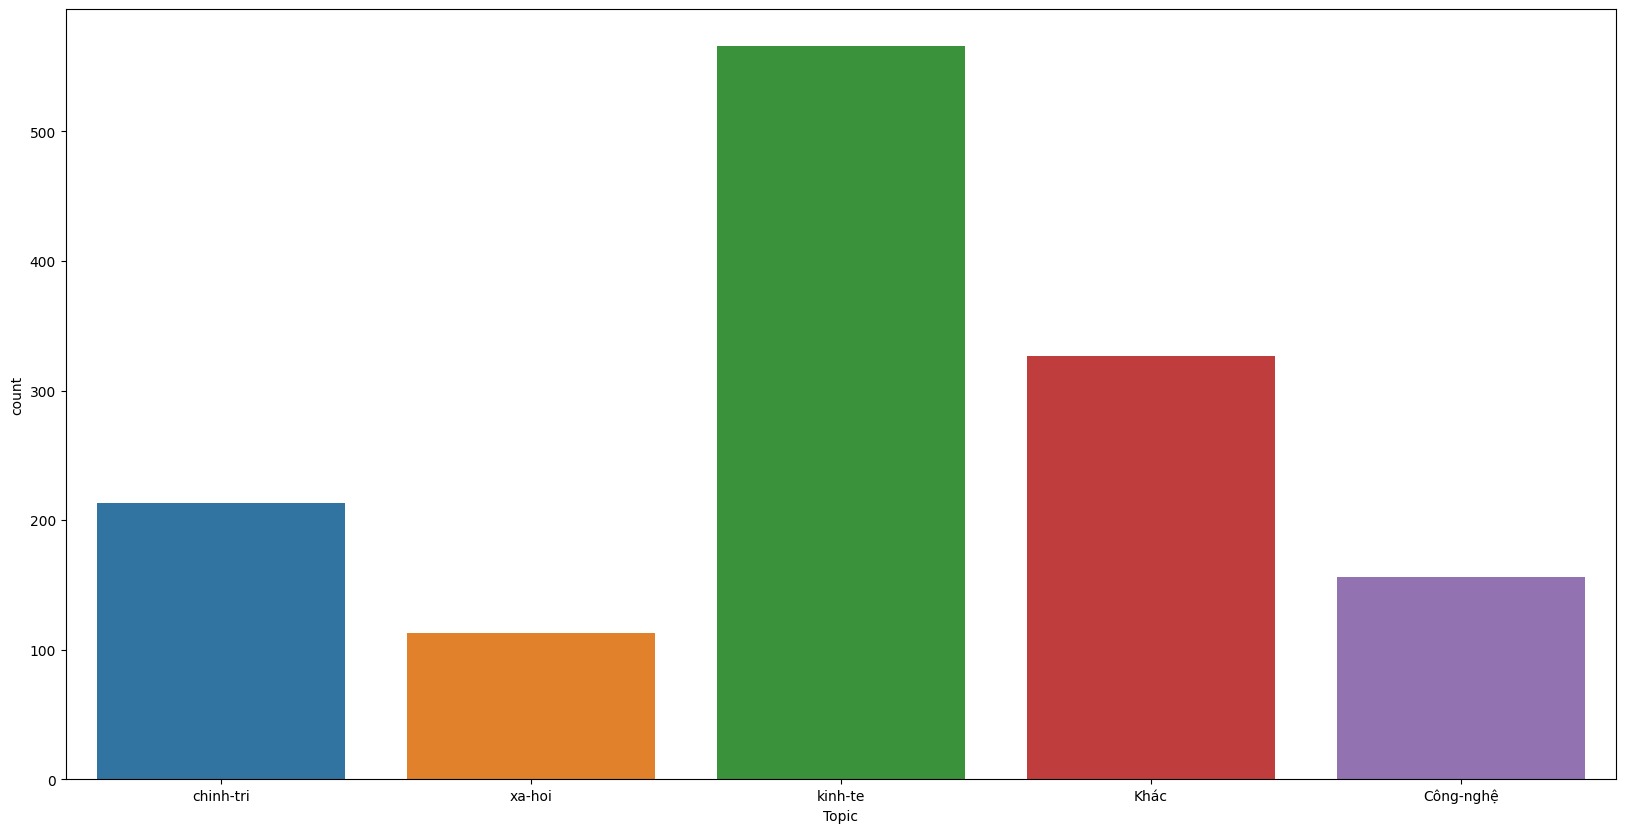

In [72]:
plot_topic(df_small)

In [73]:
df_big['Topic'].value_counts()

Khác         5184
kinh-te      2326
chinh-tri    1856
xa-hoi       1005
Công-nghệ     548
Name: Topic, dtype: int64

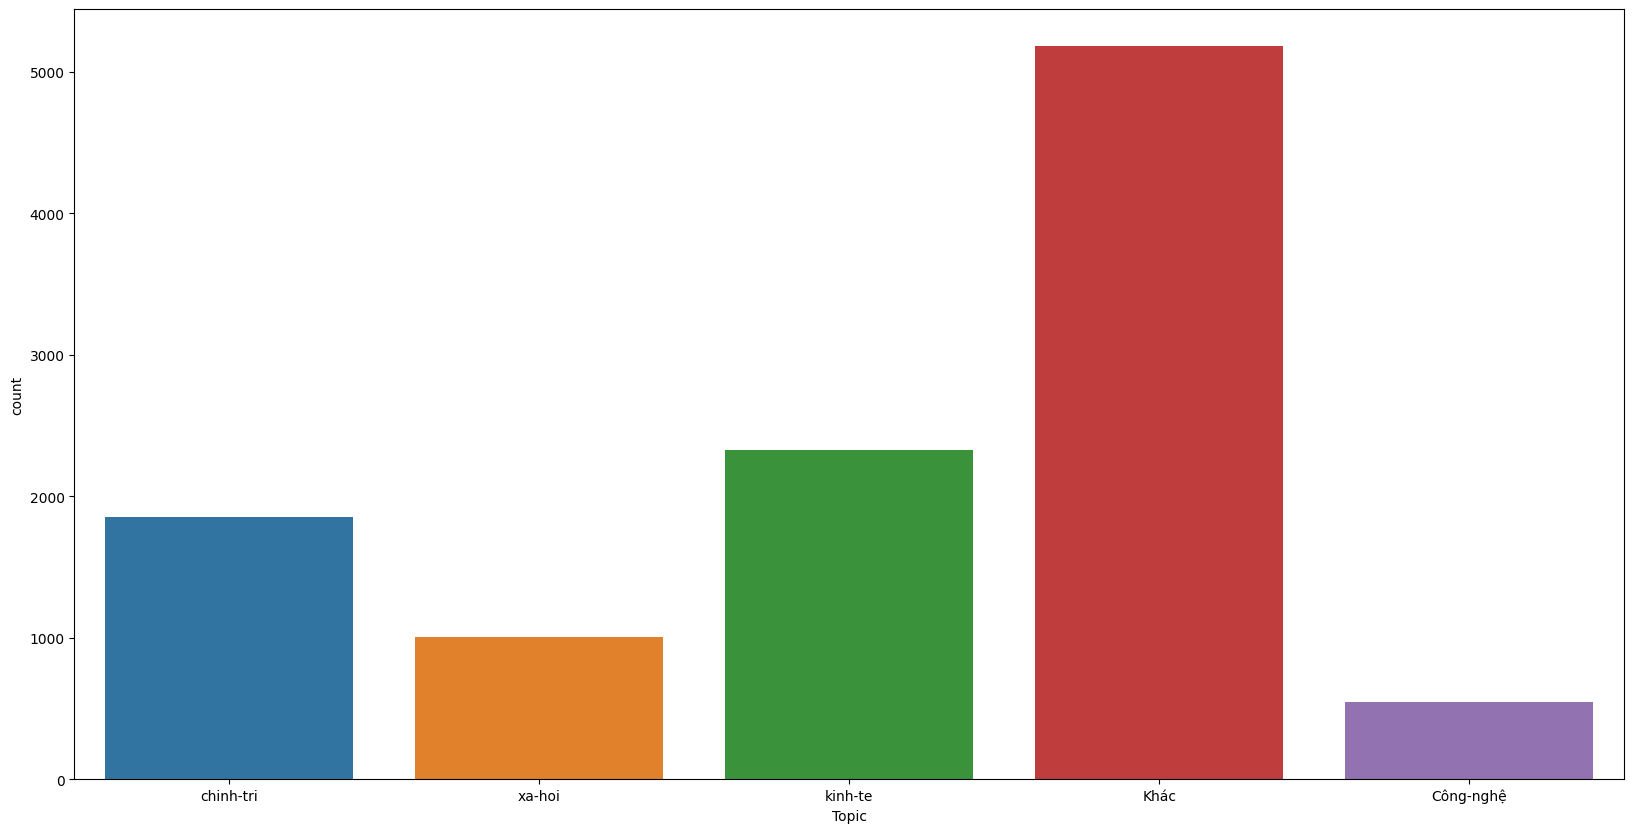

In [74]:
plot_topic(df_big)

In [75]:
from collections import Counter

top = Counter([item for sublist in df_big['Content'].apply(lambda x:str(x).split()) for item in sublist])
print(len(top))
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

3231


,Common_words,count
0,-,1662
1,của,1634
2,Nam,1090
3,Việt,1052
4,trong,925
5,đời,747
6,cho,735
7,Tập,706
8,sao,681
9,vẫn,681


In [76]:
import plotly.express as px

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Contents', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

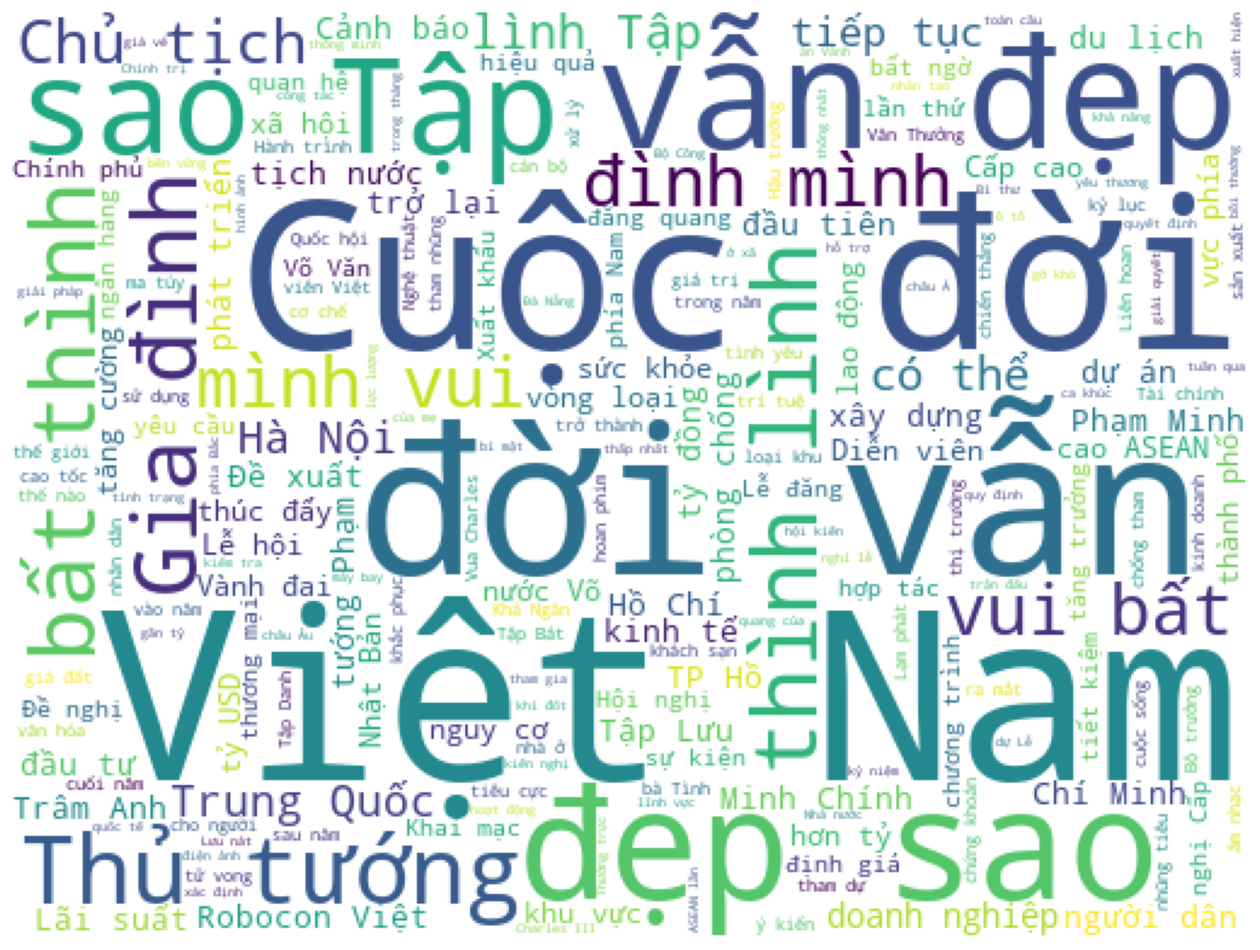

In [77]:
from wordcloud import WordCloud

plt.subplots(figsize = (16,16))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(df_big['Content']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('Plotly-World_Cloud.png')
plt.show()

## Cleaning and Processing data

In [78]:
stop_words = set(stopwords.words('vietnamese')) 

In [79]:
def remove_stop_words(content):
    text = ' '.join(word for word in content.split() if word not in stop_words)
    return text

In [80]:
def removing_numbers(content):
    content = ''.join([i for i in content if not i.isdigit()])
    return content

In [81]:
def lower_case(content):
    content = content.split()
    content = [y.lower() for y in content]
    return " " .join(content)

In [82]:
def Removing_punctuations(content):
    ## Remove punctuations
    content = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', content)
    content = content.replace('؛',"", )
    
    ## remove extra whitespace
    content = re.sub('\s+', ' ', content)
    content =  " ".join(content.split())
    return content.strip()

In [83]:
def normalized_sentence(content):
    content = lower_case(content)
    content = Removing_punctuations(content)
    content = remove_stop_words(content)
    content = removing_numbers(content)
    return content

In [84]:
def normalize_text(df):
    df['Content'] = df['Content'].apply(lambda content : lower_case(content))
    df['Content'] = df['Content'].apply(lambda content : remove_stop_words(content))
    df['Content'] = df['Content'].apply(lambda content : Removing_punctuations(content))
    df['Content'] = df['Content'].apply(lambda content : removing_numbers(content))
    return df

In [85]:
df_small.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [86]:
df_big.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [87]:
df_small = normalize_text(df_small)
df_big = normalize_text(df_big)

In [88]:
df_small.head()

,Content,Topic
0,quán triệt quy định ban bí thư báo chí xuất t...,chinh-tri
1,phó thủ tướng trần hồng hà vaccine tiêm chủng ...,chinh-tri
2,asean ứng năng động cường sức thân,chinh-tri
3,tiếp tục hoàn thiện chế xác định giá đất,chinh-tri
4,công an trao tặng giải thưởng trần quốc hoàn,chinh-tri


## Extract feature -> endcode

In [89]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import LabelEncoder

In [90]:
# Load pre-trained PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")
encode_lable = LabelEncoder()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [91]:
# Define a function to generate sentence embeddings
def generate_sentence_embedding(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Generate the embedding
    with torch.no_grad():
        output = model(input_ids)
        embedding = output[0][0][0].numpy()
    return embedding

In [92]:
def encode_lables(df):
    encode_lable.fit(df['Topic'])
    df['Topic'] = encode_lable.transform(df['Topic'])  

In [93]:
def embedding_sentences(df):
    df['Content_embedding'] = df['Content'].apply(lambda content : generate_sentence_embedding(content))

In [94]:
encode_lables(df_small)
embedding_sentences(df_small)
df_small.head()

,Content,Topic,Content_embedding
0,quán triệt quy định ban bí thư báo chí xuất t...,2,"[-0.1469182, -0.052693933, -0.5904914, -0.4528..."
1,phó thủ tướng trần hồng hà vaccine tiêm chủng ...,2,"[0.1869496, 0.5510812, -0.31150234, -0.6922819..."
2,asean ứng năng động cường sức thân,2,"[-0.08028769, 0.7538048, -0.87625635, -0.43178..."
3,tiếp tục hoàn thiện chế xác định giá đất,2,"[0.23981127, 0.5413085, -0.047829904, -0.30850..."
4,công an trao tặng giải thưởng trần quốc hoàn,2,"[0.105729684, 0.47408032, -0.33820128, -0.4237..."


In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [96]:
def get_F1(trained_model,X,y):

    predicted = trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1 = f1_score(y, predicted, average=None)
    # Return the F1 score
    return f1

In [97]:
def training_model(model, X_train, y_train):
    return model.fit(X_train, y_train)

In [98]:
def eveluation_model(model, X_test, y_test):
    #test the model with the test data
    y_pred = model.predict(X_test)
    #calculate the accuracy
    log_reg_accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', log_reg_accuracy,'\n')

    #calculate the F1 score
    f1_Score = get_F1(model,X_test,y_test)
    return pd.DataFrame(f1_Score, index= df_small['Topic'].unique(), columns=['F1 score'])

In [99]:
X = df_small["Content_embedding"].values
X = np.vstack(X)
y = df_small["Topic"].values

In [100]:
X_train,X_test,y_train,y_test = train_test_split(X , y, test_size = 0.3, random_state = 6, stratify = y)

In [101]:
knn = training_model( KNeighborsClassifier(n_neighbors=5), X_train, y_train)

In [102]:
svc =  training_model(SVC(kernel='linear', probability=True), X_train, y_train)

In [103]:
rdf =  training_model(RandomForestClassifier(n_estimators=100, random_state=42), X_train, y_train) 

In [104]:
eveluation_model(knn, X_test ,y_test)

Accuracy:  0.8038740920096852 



,F1 score
2,0.735632
4,0.804469
3,0.755556
1,0.865591
0,0.603774


In [105]:
eveluation_model(svc, X_test ,y_test)

Accuracy:  0.9515738498789347 



,F1 score
2,0.857143
4,0.984925
3,0.944000
1,0.960227
0,0.939394


In [106]:
eveluation_model(rdf, X_test ,y_test)

Accuracy:  0.9394673123486683 



,F1 score
2,0.794872
4,0.965517
3,0.913386
1,0.963173
0,0.953846
